In [8]:
import subprocess


def run(n: int):
    result = subprocess.run(
        ["mpirun", "-n", str(n), "python", "multi.py"], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")

    return result

In [9]:
print(run(4))

Process 0: [{'file': 'data_200.csv', 'start': 0, 'end': 200}, {'file': 'data_300.csv', 'start': 0, 'end': 175}]
Process 1: [{'file': 'data_300.csv', 'start': 175, 'end': 300}, {'file': 'data_1000.csv', 'start': 0, 'end': 250}]
Process 2: [{'file': 'data_1000.csv', 'start': 250, 'end': 625}]
Process 3: [{'file': 'data_1000.csv', 'start': 625, 'end': 1000}]
Communication time takes 0.0071 seconds for processor 2
Communication time takes 0.0117 seconds for processor 3
Communication time takes 0.0050 seconds for processor 4
Communication time takes 0.0226 seconds for processor 1
Sequential KMeans
[[0.77290211 0.34634568]
 [0.24639257 0.28206578]
 [0.4527302  0.79163638]]
Parallel KMeans
[[0.77763041 0.34234131]
 [0.24827524 0.28338257]
 [0.45233271 0.79136346]]
Scikit KMeans
[[0.76416462 0.3221683 ]
 [0.23752843 0.29437459]
 [0.47669512 0.79145383]]



In [10]:
import re


def data_load_ts_extractor(text: str):
    pattern = r"Data Loader takes ([0-9.]+) seconds for processor (\d+)"

    # Search for the pattern in the text
    match = re.search(pattern, text)

    # Extract process ID and time elapsed
    if match:
        time_elapsed = match.group(2)
        process_id = match.group(1)
        return (process_id, time_elapsed)

    return (None, None)


def communication_time_ts_extractor(text: str):
    pattern = r"Communication time takes ([0-9.]+) seconds for processor (\d+)"

    # Search for the pattern in the text
    match = re.search(pattern, text)

    # Extract process ID and time elapsed
    if match:
        time_elapsed = match.group(1)
        process_id = match.group(2)
        return (process_id, time_elapsed)

    return (None, None)


def whole_time_ts_extractor(text: str):
    pattern = r"Whole Processing takes ([0-9.]+) seconds for processor (\d+)"

    # Search for the pattern in the text
    match = re.search(pattern, text)

    # Extract process ID and time elapsed
    if match:
        time_elapsed = match.group(1)
        process_id = match.group(2)
        return (process_id, time_elapsed)

    return (None, None)

In [11]:
metrics = {}


def get_mtrics(n: int):
    communication_times = []

    for x in run(n).split("\n"):
        (process_id, communication_time) = communication_time_ts_extractor(x)
        if process_id and communication_time:
            communication_times.append((int(process_id), float(communication_time)))

    # calculate mean times
    communication_times_mean = sum([x[1] for x in communication_times]) / len(
        communication_times
    )

    metrics[n] = communication_times_mean

In [12]:
for i in range(1, 7):
    get_mtrics(i)

In [13]:
print(metrics)

{1: 0.0028, 2: 0.0056, 3: 0.025033333333333335, 4: 0.025500000000000002, 5: 0.01134, 6: 0.015316666666666666}


/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

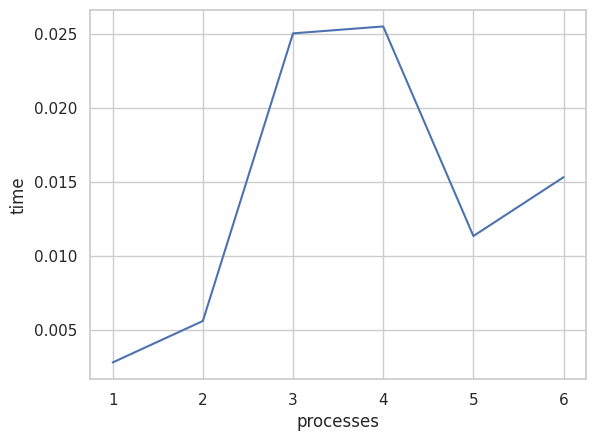

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")

# show communication mean time
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["time"])
df = df.reset_index().rename(columns={"index": "processes"})
sns.lineplot(data=df, x="processes", y="time")
plt.show()